# XAI - TABNET

## Loading libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import shutil
import tensorflow as tf
import tabnet

2022-12-28 20:34:03.418742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

In [25]:
def plot_masks(model):
    for i, mask in enumerate(model.tabnet.feature_selection_masks, 1):
        print(f"Mask n. {i}")
        fig, ax = plt.subplots(figsize=(5, 20))
        ax.imshow(mask[0])
        plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical") 
        plt.show()

    print("Aggregated mask")
    fig, ax = plt.subplots(figsize=(5, 20))
    ax.imshow(model.tabnet.aggregate_feature_selection_mask[0])
    plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical") 
    plt.show()

In [27]:
def plot_averaged_masks(model):
    for i, mask in enumerate(model.tabnet.feature_selection_masks, 1):
        print(f"Mask n. {i}")
        fig, ax = plt.subplots(figsize=(5, 10))
        avg = np.mean(mask[0], axis=0)
        ax.imshow([avg/np.sum(avg)])
        plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical")
        plt.yticks([])
        plt.show()
    
    print("Aggregated mask")
    fig, ax = plt.subplots(figsize=(5, 10))
    avg = np.mean(model.tabnet.aggregate_feature_selection_mask[0], axis=0)
    ax.imshow([np.array(avg)/np.sum(avg)])
    plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical")
    plt.yticks([])
    plt.show()

## Loading data

In [4]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    11508 non-null  object 
 1   lang                    11508 non-null  object 
 2   bot                     11508 non-null  int64  
 3   created_at              11508 non-null  object 
 4   statuses_count          11508 non-null  int64  
 5   avg_length              11508 non-null  float64
 6   avg_special_chars       11508 non-null  float64
 7   urls_ratio              11508 non-null  float64
 8   mentions_ratio          11508 non-null  float64
 9   hashtags_ratio          11508 non-null  float64
 10  reply_count_mean        11508 non-null  float64
 11  reply_count_std         11508 non-null  float64
 12  favorite_count_mean     11508 non-null  float64
 13  favorite_count_std      11508 non-null  float64
 14  favorite_count_entropy  1

In [6]:
data.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903,0.232481
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495,0.167568
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008,0.392850
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619,0.120737


## Preprocessing of the data

In [7]:
target = data.pop('bot')

We remove the **created at** feature, since without it the TabNet method is more effective and we can reach better accuracy.

In [8]:
# convert datetime to timestamp to permit classification
# data["created_at"] = pd.to_datetime(data.created_at).values.astype(np.int64) // 10 ** 9
del data["created_at"]

In [9]:
# categorical_features = ["lang", "bot", "created_at", "name"]
categorical_features = ["lang", "name"]

# remove categorical variables
numerical_features = list(data.columns).copy()

for feat in categorical_features:
    numerical_features.remove(feat)

In [10]:
numerical_features

['statuses_count',
 'avg_length',
 'avg_special_chars',
 'urls_ratio',
 'mentions_ratio',
 'hashtags_ratio',
 'reply_count_mean',
 'reply_count_std',
 'favorite_count_mean',
 'favorite_count_std',
 'favorite_count_entropy',
 'retweet_count_mean',
 'retweet_count_std',
 'retweet_count_entropy']

In [11]:
numerical_data = data[numerical_features]

In [12]:
numerical_data.head()

,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std,retweet_count_entropy
2353593986,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903,0.232481
2358850842,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495,0.167568
137959629,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
466124818,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008,0.392850
2571493866,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619,0.120737


In [13]:
target.head()

2353593986    1
2358850842    0
137959629     1
466124818     1
2571493866    0
Name: bot, dtype: int64

In [14]:
numerical_dataset = tf.data.Dataset.from_tensor_slices((numerical_data, target))

2022-12-28 20:34:10.849857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
def transform(data, target):
    data = tf.unstack(data)
    
    x = dict(zip(numerical_features, data))
    y = tf.one_hot(target, 2)
    
    return x, y

In [16]:
BATCH_SIZE = 128

train_size = int(data.shape[0] / 100 * 70)

In [17]:
ds_full = numerical_dataset.shuffle(data.shape[0], seed=0)
# ds_full = numerical_dataset

In [18]:
ds_train = ds_full.take(train_size)
ds_train = ds_train.map(transform)
ds_train = ds_train.batch(BATCH_SIZE)
ds_test = ds_full.skip(train_size)
ds_test = ds_test.map(transform)
ds_test = ds_test.batch(BATCH_SIZE)

feature_columns = []
for col_name in numerical_features:
    feature_columns.append(tf.feature_column.numeric_column(col_name))

In [19]:
feature_columns

[NumericColumn(key='statuses_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='avg_length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='avg_special_chars', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='urls_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mentions_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='hashtags_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='reply_count_mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='reply_count_std', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='favorite_count_mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='favor

## Defining and training the model

In [20]:
# Group Norm does better for small datasets
model = tabnet.TabNetClassifier(feature_columns, num_classes=2,
                                feature_dim=8, output_dim=4,
                                num_decision_steps=4, relaxation_factor=1.0,
                                sparsity_coefficient=1e-5, batch_momentum=0.98,
                                virtual_batch_size=None, norm_type='group',
                                num_groups=1)
                                

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.0012, decay_steps=100, decay_rate=0.9, staircase=False)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

[TabNet]: 4 features will be used for decision steps.


In [21]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model.fit(ds_train, epochs=100, validation_data=ds_test, callbacks=[early_stopping_callback])

model.summary()

Epoch 1/100
63/63 [==============================] - 8s 22ms/step - loss: 0.4250 - accuracy: 0.8110 - val_loss: 0.3747 - val_accuracy: 0.8372
Epoch 2/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3622 - accuracy: 0.8489 - val_loss: 0.3548 - val_accuracy: 0.8584
Epoch 3/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3476 - accuracy: 0.8592 - val_loss: 0.3418 - val_accuracy: 0.8578
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3347 - accuracy: 0.8647 - val_loss: 0.3334 - val_accuracy: 0.8627
Epoch 5/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3314 - accuracy: 0.8619 - val_loss: 0.3328 - val_accuracy: 0.8610
Epoch 6/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3273 - accuracy: 0.8673 - val_loss: 0.3174 - val_accuracy: 0.8703
Epoch 7/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3271 - accuracy: 0.8649 - val_loss: 0.3452 - val_accuracy: 0.8561
Epoch 8/100


 transform_block_12 (Transfo  multiple                 84        
 rmBlock)                                                        
                                                                 
Total params: 1,976
Trainable params: 1,976
Non-trainable params: 0
_________________________________________________________________


## Evaluation and explanation plots

In [22]:
results = model.evaluate(ds_test, batch_size=128)
print("test loss, test acc:", results)

27/27 [==============================] - 0s 6ms/step - loss: 0.2981 - accuracy: 0.8830
test loss, test acc: [0.2980612814426422, 0.8830003142356873]


In [23]:
# Force eager execution mode to generate the masks
x, y = next(iter(ds_train))

_ = model(x)

### Explanations

More yellow cells indicate the most important features for a certain sample.
In the following plots we can see the masks generated by the TabNet algorithm. The last one is the aggregation of the previous ones.

Mask n. 1


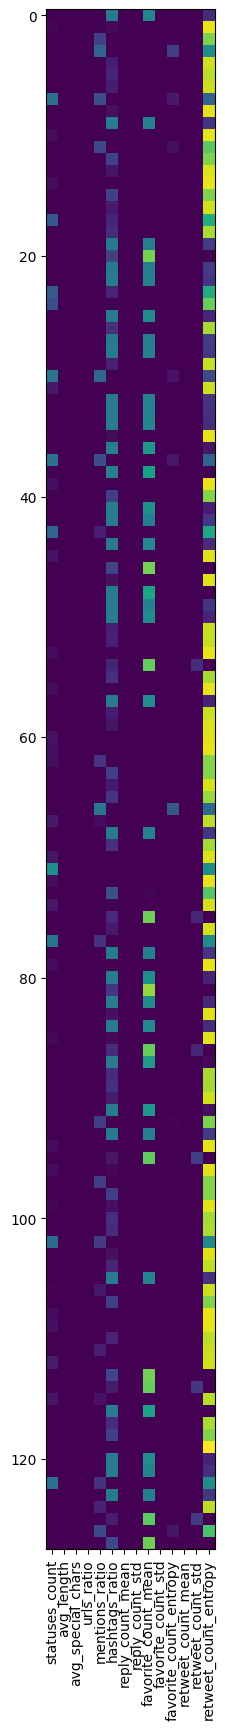

Mask n. 2


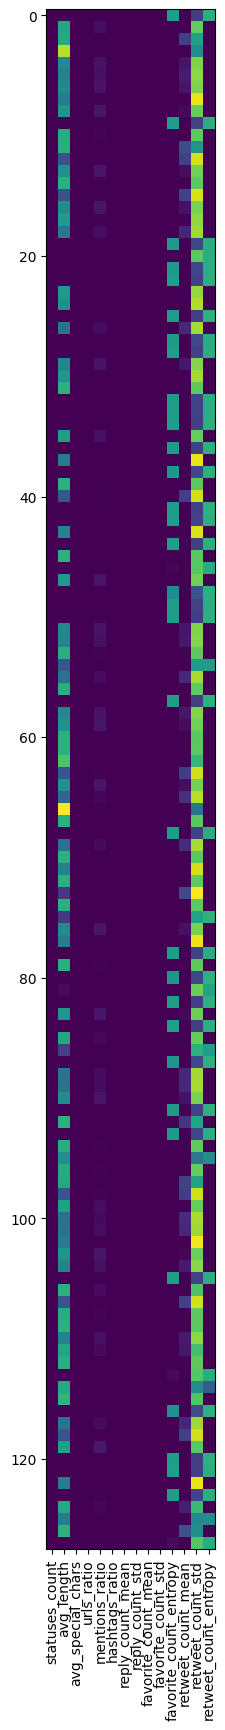

Mask n. 3


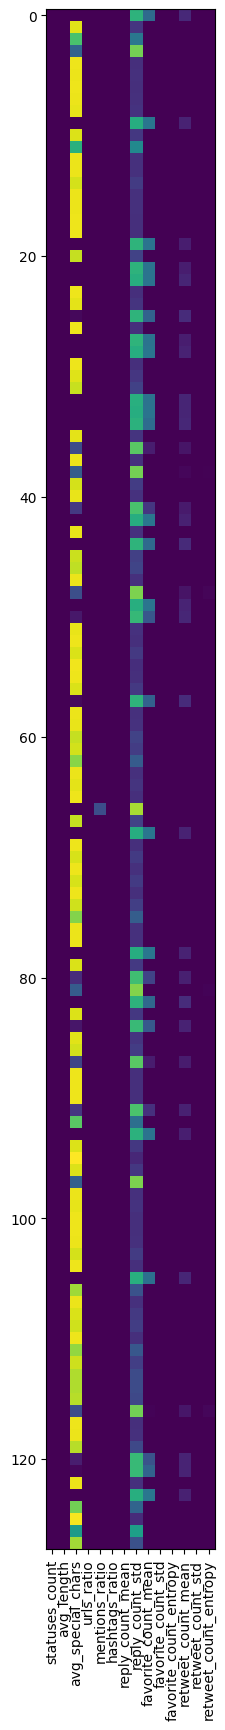

Aggregated mask


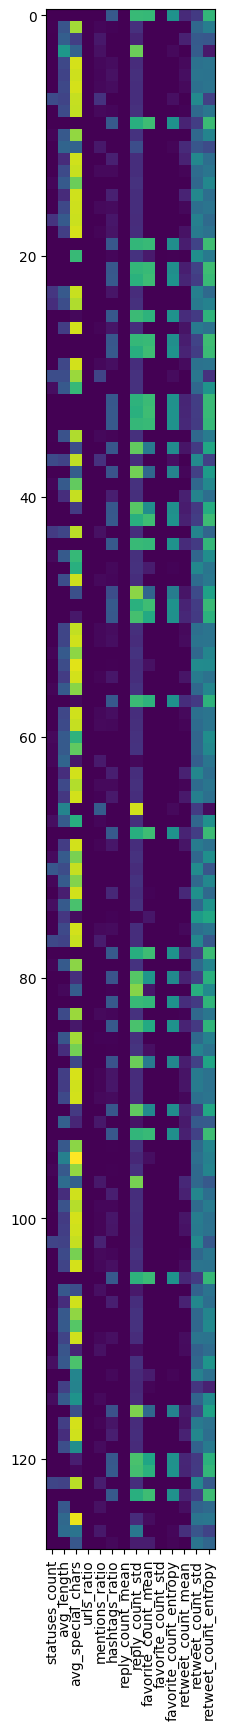

In [26]:
plot_masks(model)

Now we report the average of the masks over the different samples.

We can see in the aggregation of the masks, that the results are not consistent with the other XAI methods that show the **statuses count** as the most important feature. In this case the masks focuse on different features, like **retweet count entropy** (in the first mask), **retweet count std** (in the second mask) and so on.

Mask n. 1


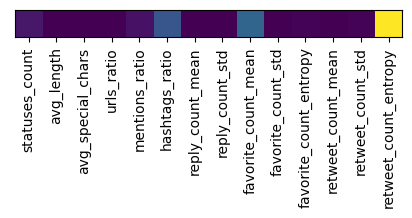

Mask n. 2


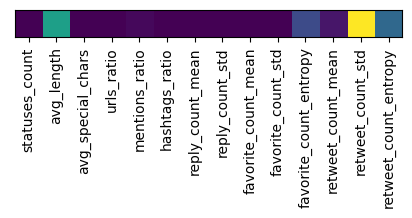

Mask n. 3


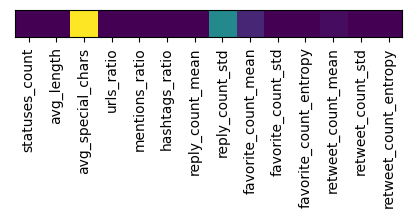

Aggregated mask


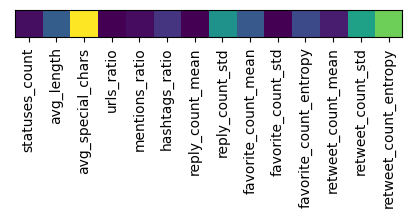

In [28]:
plot_averaged_masks(model)